In [249]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

import math
import os
import json
import pandas as pd

import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw

# PubLayNet dataset analysis

Source: https://github.com/ibm-aur-nlp/PubLayNet

A critical challenge for automated information extraction from scientific literature is that documents often contain content that is not in natural language, such as figures and tables. Nevertheless, such content usually obtain a comprehensive understanding of scientific literature, the automated system must be able to recognize the layout of the documents and parse the non-natural-language content into a machine readable format.

ICDAR 2021 Scientific Literature Parsing Competition aims to drive the advances specifically in the following two problems:

1) Task A: Document Layout Recognition: Identifying the position and category of document layout elements, including title, text, figure, table and list

2) Task B: Table Recognition: Given an image of a document page, generate the corresponding HTML code which correctly represents for each table both the structure and contents of each table cell.


* Articles in PubLayNet dataset are from PubMed Central archive

* Task A aims to advance the research in recognizing the layout of understanding documents. The idea behind this task is to develop a model that can identify the common layout elements in document images, including text, titles, tables, figures and lists, **with confidence score for each detection**.

* Annotation are automatically generated by matching the PDF format and the XML format of the articles in the PubMed Central Open Access subset

* Results are evaluated using **mean average precision** (MAP) at **intersection over union** (IoU) metric on bounding boxes and **mean of the average precision** on all element categories

### Results

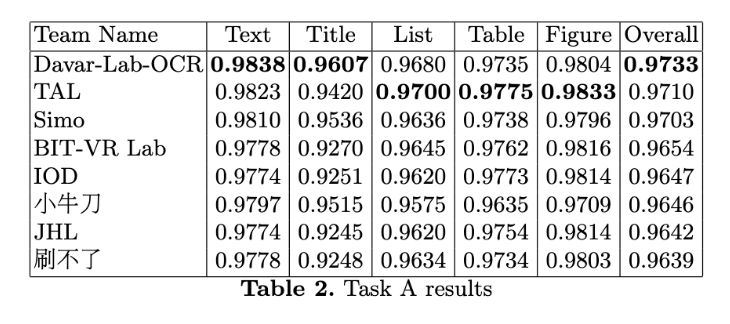

1) **Davar-Lab-OCR**: Used ensemble technique with two RCNN

2) **TAL**: RCNN and modified LayoutLM

Competition: https://github.com/ibm-aur-nlp/PubLayNet/blob/master/ICDAR_SLR_competition/ICDAR_2021_Scientific_Literature_Parsing.pdf



In [24]:
labels = json.loads(Path("../data/publaynet/train.json").read_text())

images = pd.DataFrame(labels["images"])
annotations = pd.DataFrame(labels["annotations"])
categories = pd.DataFrame(labels["categories"])

## Data exploration

In [132]:
samples = [{"samples_count": len(images), "labels_count": len(annotations), "categories": len(categories)}]
short_stats = pd.DataFrame(samples)
short_stats

samples_count  labels_count  categories
0         335703       3263046           5

In [25]:
images

file_name  height      id  width
0       PMC3866684_00003.jpg     811       0    613
1       PMC3866684_00001.jpg     811       1    613
2       PMC3866684_00002.jpg     811       2    613
3       PMC3866684_00005.jpg     811       3    613
4       PMC3866684_00006.jpg     811       4    613
...                      ...     ...     ...    ...
335698  PMC3743259_00001.jpg     791  340386    613
335699  PMC3743259_00002.jpg     791  340387    613
335700  PMC3743259_00004.jpg     791  340388    613
335701  PMC3743259_00006.jpg     791  340389    613
335702  PMC3743259_00007.jpg     791  340390    613

[335703 rows x 4 columns]

In [26]:
annotations

segmentation          area  \
0        [[52.38, 444.87, 291.97, 444.87, 291.97, 456.4...  13787.433083   
1        [[309.91, 444.91, 561.46, 444.91, 561.46, 456....   3266.252634   
2        [[52.38, 507.66, 291.97, 507.66, 291.97, 519.1...   8037.095047   
3        [[321.87, 465.8, 561.46, 465.8, 561.46, 477.34...  18566.000169   
4        [[40.42, 397.09, 561.44, 397.09, 561.44, 405.5...  17140.380181   
...                                                    ...           ...   
3263041  [[328.08, 163.62, 542.17, 163.62, 542.17, 175....  60349.788331   
3263042  [[315.1, 468.23, 542.2, 468.23, 542.2, 481.27,...  46676.227587   
3263043  [[328.08, 675.15, 542.23, 675.15, 542.23, 686....  11348.987092   
3263044  [[70.02, 176.74, 149.09, 176.74, 149.09, 191.9...   1204.374589   
3263045  [[315.1, 450.51, 373.76, 450.51, 373.76, 465.7...    893.506519   

         iscrowd  image_id                             bbox  category_id  \
0              0         0   [40.42, 444.87, 251.55, 63.86]            1   
1              0         0  [309.91, 444.91, 251.55, 21.97]            1   
2              0         0   [40.42, 507.66, 251.55, 32.45]            1   
3              0         0    [309.91, 465.8, 251.55, 74.3]            1   
4              0         0   [40.42, 397.09, 521.02, 34.83]            1   
...          ...       ...                              ...          ...   
3263041        0    340390  [315.1, 163.62, 227.14, 270.83]            1   
3263042        0    340390  [315.1, 468.23, 227.16, 205.62]            1   
3263043        0    340390   [315.1, 675.15, 227.18, 50.81]            1   
3263044        0    340390    [70.02, 176.74, 79.07, 15.23]            2   
3263045        0    340390    [315.1, 450.51, 58.66, 15.23]            2   

              id  
0              0  
1              1  
2              2  
3              3  
4              4  
...          ...  
3263041  3311655  
3263042  3311656  
3263043  3311657  
3263044  3311658  
3263045  3311659  

[3263046 rows x 7 columns]

In [27]:
categories

supercategory  id    name
0                 1    text
1                 2   title
2                 3    list
3                 4   table
4                 5  figure

### Category balance

Counter({1: 2343356, 2: 627125, 5: 109292, 4: 102514, 3: 80759})


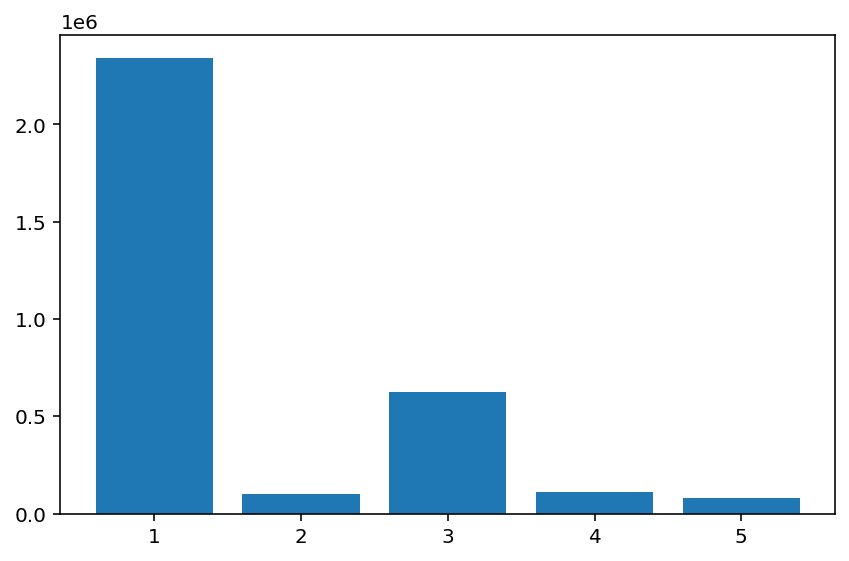

In [133]:
from collections import Counter
counts = Counter(annotations["category_id"])
print(counts)

fig, ax = plt.subplots(tight_layout=True)
hist = ax.bar(range(1,len(counts)+1), counts.values())

### Factor of the number of classes


[✔] We have atleast factor of 1 for each class.
[✗] We are missing category: 'mathematical formulas'


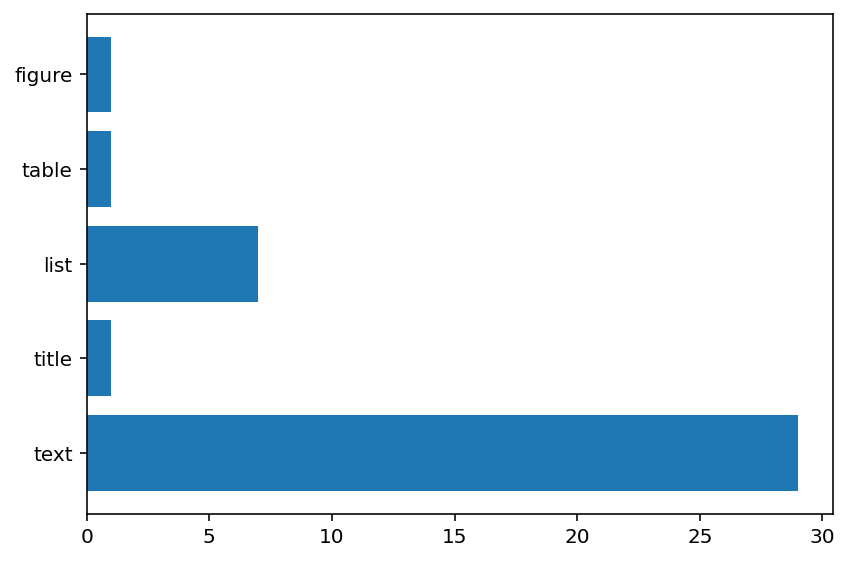

In [357]:
k = min(counts.values())
factors = {klass: occ//k for klass, occ in counts.items()}

fig, ax = plt.subplots(tight_layout=True)
ax.barh(range(0,len(factors)), factors.values())
ax.set_yticks(np.arange(len(factors)))
ax.set_yticklabels(list(categories["name"][0:5]))

print("[✔] We have atleast factor of 1 for each class.")
print("[✗] We are missing category: 'mathematical formulas'")

In [326]:
all(annotations["iscrowd"] == 0)

True

## Data understanding

Reading order:  [115, 106, 107, 116, 108, 117, 110, 109, 118, 111, 112, 113, 119, 114]


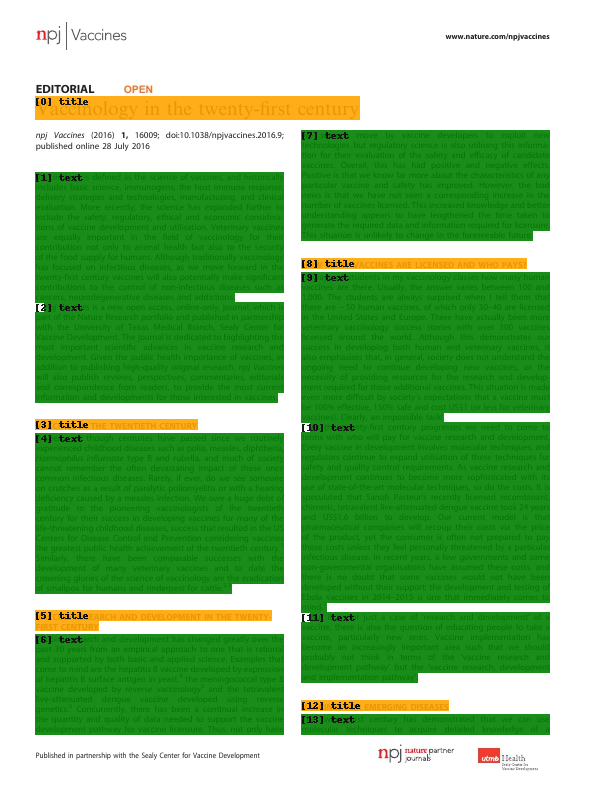

In [363]:
def get_image(image_id, images):
    """Get image based on given annotation."""
    record = images[images["id"] == image_id]
    img_path = (Path.cwd() / ".." / "data" / "publaynet" / "train" / record["file_name"][image_id]).resolve()
    
    return Image.open(str(img_path)).convert("RGBA"), record


def get_sample(image_id, images, annotations):
    """Get image data, metadata and annotation."""
    img, metadata = get_image(image_id, images)
    return img, metadata, annotations[annotations["image_id"] == image_id]


def id_to_text(category_id):
    """Convert category id to text."""
    colors = {
        1: "text", 
        2: "title",
        3: "list", 
        4: "table",
        5: "figure",
    }
    return colors[category_id]


def id_to_color(category_id):
    """Convert category id to color."""
    colors = {
        1: "green",   # text
        2: "orange",  # title
        3: "weat",    # list
        4: "blue",    # table
        5: "gray",    # figure
    
    }
    return colors[category_id]
        

def label_point(points):
    """Returns left most point."""
    from shapely.geometry import Polygon
    from shapely.algorithms.polylabel import polylabel
    
    poly = Polygon([[points[i], points[i+1]] for i in range(0, len(points), 2)])
    p_text = polylabel(poly, tolerance=10)
    return (p_text.x, p_text.y)


image_id = 15
img, metadata, labels = get_sample(image_id, images, annotations)

img2 = img.copy()
draw = ImageDraw.Draw(img2)

reading_order = []
idx = 0
for index, row  in labels[["segmentation", "category_id", "id", "bbox"]].sort_values(by=['bbox']).iterrows():
    poly = row["segmentation"][0]
    draw.polygon(poly, fill=id_to_color(row["category_id"]))
    
    poly_id = idx
    category_text = id_to_text(row["category_id"])
    
    xis = sum([poly[i] for i in range(0, len(poly), 2)]) / (len(poly)/2)
    yis = sum([poly[i] for i in range(1, len(poly), 2)]) / (len(poly)/2)
    
    p_text = (row["bbox"][0], row["bbox"][1]) 
    draw.text(p_text, f"[{poly_id}] {category_text}", fill="black")
    reading_order.append((p_text, index, category_text))
    idx += 1


img3 = Image.blend(img, img2, 0.9)

reading_order.sort()
print("Reading order: ", [r[1] for r in reading_order])

img3

## Conclusion

#### Pros

1) Considering dataset heuristics it contains enough data per class to train "deep" models

2) Segment polygons could be used to geometrically determine reading order

3) Dataset contains pretrained examples which could be applied for transfer learning

4) Dataset contains unbalanced classes, however it's sufficiently large to in each class to not be a problem


#### Cons

1) Dataset is not very large (could be a potential problem for more complicated models)

2) Segment polygons are missing "mathematical formula" category

3) Dataset generally is missing mathematical formulas in it's text polygons

4) Dataset contains pages which are small resolution and running Tesseract OCR on them is sometimes not very successful (I'm still working on exploring this), which could be a problem for building multimodal data (and analysis of multimodal models) 


### Points to focus on

1) Expand segmentation category with mathematical formulas

2) Increase quality of page photos or extract text data from the source to utilize multi-modality

3) Build a dataset which contains more mathematical formulas in text or figures

4) Expand the dataset with more data for larger architectures


